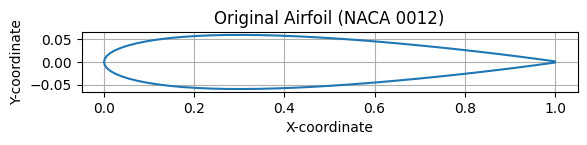

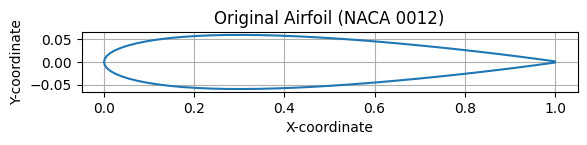

In [1]:
from scipy.optimize import minimize
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
%run 2.Hicks_Henne_NEW_Final.ipynb
%run 3.Xfoil_runner_extract_value.ipynb

In [2]:
model = joblib.load('model__24_rmse.joblib')
scaler = joblib.load('scaler_file__24_rmse.joblib')

In [3]:
# Save the current directory
original_directory = os.getcwd()

# Navigate to another folder
os.chdir(original_directory + '\\Deformed_foils')

In [4]:
airfoil_name = '0rig_NACA0012'

CL_org, CD_org = Xfoil_runner(alpha, Re, n_iter, airfoil_name)

print(CL_org, CD_org)

0.5572 0.00848


In [5]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]

In [6]:
def objective_function(design_parameters):
    design_parameters = design_parameters.reshape(1,8)
    design_parameters = pd.DataFrame(design_parameters, columns=feature_names)
    design_parameters = scaler.transform(design_parameters)
    
    predictions = model.predict(design_parameters)
    CL = predictions[0, 0]
    CD = predictions[0, 1]
    
    efficiency = CL / CD
    return -efficiency

def CD_constraint(design_parameters):
    design_parameters = design_parameters.reshape(1,8)
    design_parameters = pd.DataFrame(design_parameters, columns=feature_names)
    design_parameters = scaler.transform(design_parameters)
    
    predictions = model.predict(design_parameters)
    CL = predictions[0, 0]
    CD = predictions[0, 1]  
    
    return CD_org - CD
    
def area_constraint(design_parameters):
    design_parameters = np.array(design_parameters).reshape((1, 8))
    i = 0
    y_mod = hicks_henne_overall(x, y , n, design_parameters, i, w, xM)
    polygon1 = Polygon(zip(x, y))
    area_orig = polygon1.area
    polygon2 = Polygon(zip(x, y_mod))
    area_mod = polygon2.area
    return area_orig - area_mod


In [7]:
bounds = [(-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit) ]
#scale
initial_guess = np.full(8,0.008)

In [8]:
from shapely.geometry import Polygon
constraints = [{'type': 'ineq', 'fun': CD_constraint},{'type': 'eq', 'fun': area_constraint}]
# constraints = [{'type': 'ineq', 'fun': CD_constraint}]
result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

optimal_design_parameters = result.x

1/1 [==============================] - 0s 30ms/step


In [9]:
if result.success:
    print("Optimization successful!")
else:
    print("Optimization failed. Message:", result.message)

Optimization successful!


In [10]:
optimal_design_parameters = np.array(optimal_design_parameters).reshape((1, 8))
optimal_design_parameters_df = pd.DataFrame(optimal_design_parameters, columns=feature_names)
optimal_design_parameters_scaled = scaler.transform(optimal_design_parameters_df)
Optimized = model.predict(optimal_design_parameters_scaled)
CL_opt = Optimized[0, 0]
CD_opt = Optimized[0, 1]
optimal_efficiency = CL_opt/CD_opt
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient:", CL_opt )
print("Optimal Drag Coefficient:", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)

1/1 [==============================] - 0s 25ms/step
Optimal Design Parameters: [[0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012]]
Optimal Lift Coefficient: 0.8033277
Optimal Drag Coefficient: 0.0073773097
Optimal Aerodynamic Efficiency: 108.891685


In [11]:
optimal_design_parameters

array([[0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012]])

In [12]:
i = 0

In [13]:
y_opt = hicks_henne_overall(x, y , n, optimal_design_parameters, i, w, xM)

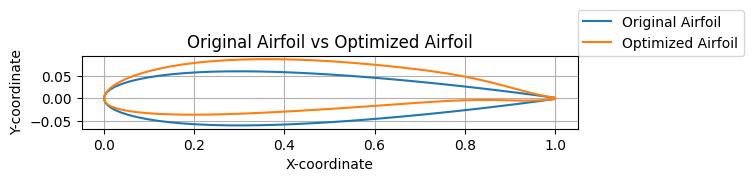

In [25]:
plt.plot(x, y, label = "Original Airfoil")
plt.plot(x, y_opt, label = "Optimized Airfoil")
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Original Airfoil vs Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend(loc=(1,1))
plt.grid()

Text(0, 0.5, 'Y-coordinate')

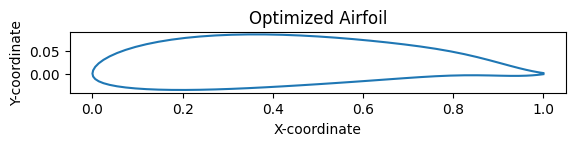

In [23]:
plt.plot(x,y_opt)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
# plt.grid()

In [16]:
df_opt = pd.DataFrame({'x': x, 'y_modified': y_opt})
path = "Optimized_airfoil.dat"
df_opt.to_csv(path, index=False, sep=' ')

In [17]:
airfoil_name = 'Optimized_airfoil'

CL, CD = Xfoil_runner(alpha, Re, n_iter, airfoil_name)

print(CL, CD)

0.9192 0.00841


In [18]:
print('Surrogate model optimization:')
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient(Surrogate model prediction):", CL_opt )
print("Optimal Drag Coefficient(Surrogate model prediction):", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)
print("Lift Coefficient for Optimal Design Parameter from XFOIL:", CL )
print("Drag Coefficient for Optimal Design Parameter from XFOIL:", CD)
Opt_eff = CL/CD
print("Optimal Aerodynamic Efficiency from XFOIL:", Opt_eff)

Surrogate model optimization:
Optimal Design Parameters: [[0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012]]
Optimal Lift Coefficient(Surrogate model prediction): 0.8033277
Optimal Drag Coefficient(Surrogate model prediction): 0.0073773097
Optimal Aerodynamic Efficiency: 108.891685
Lift Coefficient for Optimal Design Parameter from XFOIL: 0.9192
Drag Coefficient for Optimal Design Parameter from XFOIL: 0.00841
Optimal Aerodynamic Efficiency from XFOIL: 109.29845422116527


In [19]:
print("Error%")
print("Lift Coefficient Error:", abs((CL_opt-CL)*100/CL))
print("Drag Coefficient Error:", abs((CD_opt-CD)*100/CD))
print("Optimal Aerodynamic Efficiency Error:", abs((Opt_eff-optimal_efficiency)*100/Opt_eff))

Error%
Lift Coefficient Error: 12.605778978014119
Drag Coefficient Error: 12.279313618447928
Optimal Aerodynamic Efficiency Error: 0.37216330114086754


In [20]:
Org_Eff = CL_org/CD_org
print("Improvement in Efiiciency")
print("Lift and Drag Coefficient of Original Airfoil:", CL_org , CD_org)
print("Efiiciency of Original Airfoil:", CL_org/CD_org)
print("Lift and Drag Coefficient of Optimized Airfoil:", CL ,CD)
print("Efiiciency of Optimized Airfoil:", Opt_eff)
print("Improvement in Efiiciency:", abs((Opt_eff-Org_Eff)*100/Org_Eff),"%")

Improvement in Efiiciency
Lift and Drag Coefficient of Original Airfoil: 0.5572 0.00848
Efiiciency of Original Airfoil: 65.70754716981132
Lift and Drag Coefficient of Optimized Airfoil: 0.9192 0.00841
Efiiciency of Optimized Airfoil: 109.29845422116527
Improvement in Efiiciency: 66.3407917795193 %
